In [ ]:
import pandas as pd

total_df = pd.read_csv('total_df.csv')

# Filter out necessary columns
data = total_df[['game_date', 'pitcher', 'batter', 'at_bat_number', 'pitch_number',
                 'pitch_type', 'events', 'description', 'balls', 'strikes', 'outs_when_up', 'stand']]



In [31]:
# Group pitches by at-bat
at_bat_sequences = data.groupby(['game_date', 'pitcher', 'batter', 'at_bat_number'])

In [ ]:
# Group pitches by at-bat to create sequences
grouped = total_df.groupby(['game_date', 'pitcher', 'batter', 'at_bat_number'])

sequences = []

for name, group in grouped:
    pitches = group.sort_values('pitch_number')
    sequence = pitches['pitch_type'].tolist()
    pitching_plus_sequence = pitches['pitching_plus'].tolist()
    outcome = pitches['events'].iloc[-1] if 'events' in pitches.columns else None
    stand = pitches['stand'].iloc[0] if 'stand' in pitches.columns else None  # Get batter's handedness
    sequences.append({
        'pitch_sequence': sequence,
        'pitching_plus_sequence': pitching_plus_sequence,
        'outcome': outcome,
        'stand': stand,
        # Include more
    })

sequences_df = pd.DataFrame(sequences)



In [33]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Flatten the list of pitch types to create a vocabulary
all_pitches = [pitch for seq in sequences_df['pitch_sequence'] for pitch in seq]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_pitches)

# Convert sequences to numerical format
sequences_df['encoded_sequence'] = sequences_df['pitch_sequence'].apply(
    lambda seq: tokenizer.texts_to_sequences([seq])[0]
)

# Pad sequences to the same length
max_seq_length = sequences_df['encoded_sequence'].apply(len).max()
sequences_df['padded_sequence'] = pad_sequences(
    sequences_df['encoded_sequence'], maxlen=max_seq_length, padding='pre'
).tolist()


In [34]:
# Define successful and unsuccessful outcomes
success_events = ['strikeout', 'groundout', 'flyout', 'pop out', 'lineout']  # Modify as needed
fail_events = ['single', 'double', 'triple', 'home_run', 'walk', 'hit_by_pitch', 'sac_fly', 'sac_bunt']

# Create labels: 1 for success, 0 for failure
sequences_df['label'] = sequences_df['outcome'].apply(
    lambda x: 1 if x in success_events else 0
)


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Pad pitching_plus_sequence to the same length
max_seq_length_pp = sequences_df['pitching_plus_sequence'].apply(len).max()
sequences_df['padded_pitching_plus'] = pad_sequences(
    sequences_df['pitching_plus_sequence'], maxlen=max_seq_length_pp, padding='pre', dtype='float32'
).tolist()

# Convert to numpy array and reshape for LSTM input
padded_pp_list = sequences_df['padded_pitching_plus'].tolist()

# 2D numpy array
X_pp = np.array(padded_pp_list)

print('X_pp.shape:', X_pp.shape)  # Should output (num_samples, sequence_length)

X_pp = X_pp.reshape((X_pp.shape[0], X_pp.shape[1], 1))  # Shape: (samples, timesteps, features)


X_pp.shape: (185170, 16)


In [36]:
# Convert padded sequences to numpy array
X_seq = np.array(sequences_df['padded_sequence'].tolist())
y = sequences_df['label'].values


In [37]:
from sklearn.model_selection import train_test_split

# Split the data
X_seq_train, X_seq_test, X_pp_train, X_pp_test, y_train, y_test = train_test_split(
    X_seq, X_pp, y, test_size=0.2, random_state=42
)


In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate

# Parameters
vocab_size = len(tokenizer.word_index) + 1  # Plus one for padding token
embedding_dim = 50  # Dimension of the embedding vector

# Input for pitch sequences
input_seq = Input(shape=(max_seq_length,))
embedding_seq = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length)(input_seq)
lstm_seq = LSTM(64)(embedding_seq)

# Input for pitching_plus sequences
input_pp = Input(shape=(max_seq_length_pp, 1))
lstm_pp = LSTM(32)(input_pp)

# Concatenate the outputs
concat = Concatenate()([lstm_seq, lstm_pp])

# Add a fully connected layer
dense = Dense(32, activation='relu')(concat)

# Output layer
output = Dense(1, activation='sigmoid')(dense)

# Define the model
model = Model(inputs=[input_seq, input_pp], outputs=output)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [39]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [40]:
# Train the model
history = model.fit(
    [X_seq_train, X_pp_train], y_train,
    epochs=10,
    batch_size=64,
    validation_data=([X_seq_test, X_pp_test], y_test)
)


Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_8', 'keras_tensor_11']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2315/2315 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.7807 - loss: 0.4230 - val_accuracy: 0.7759 - val_loss: 0.4055
Epoch 2/10
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7850 - loss: 0.3986 - val_accuracy: 0.7923 - val_loss: 0.3974
Epoch 3/10
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.7953 - loss: 0.3933 - val_accuracy: 0.7932 - val_loss: 0.3938
Epoch 4/10
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.7968 - loss: 0.3891 - val_accuracy: 0.7927 - val_loss: 0.3977
Epoch 5/10
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8016 - loss: 0.3860 - val_accuracy: 0.7957 - val_loss: 0.3923
Epoch 6/10
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.8003 - loss: 0.3871 - val_accuracy: 0.7969 - val_loss: 0.3917
Epoch 7/10
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8006 - loss: 0.3868 - val_accuracy: 0.7938 - val_loss: 0.3917
Epoch 8/10
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8003 - loss: 0.3878 - va

In [41]:
# Evaluate the model
loss, accuracy = model.evaluate([X_seq_test, X_pp_test], y_test)
print(f'Test Accuracy: {accuracy:.2f}')


1158/1158 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7961 - loss: 0.3929
Test Accuracy: 0.79


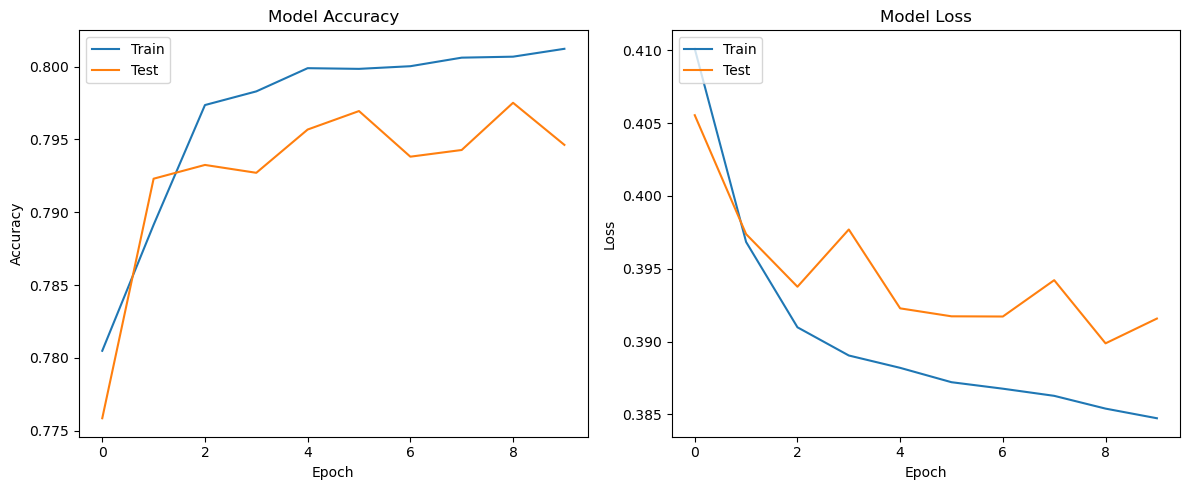

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


1158/1158 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
              precision    recall  f1-score   support

           0       0.82      0.94      0.88     28754
           1       0.58      0.30      0.39      8280

    accuracy                           0.79     37034
   macro avg       0.70      0.62      0.63     37034
weighted avg       0.77      0.79      0.77     37034



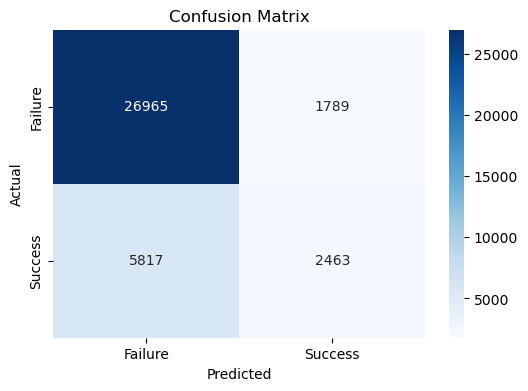

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test data
y_pred_prob = model.predict([X_seq_test, X_pp_test])
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Failure', 'Success'],
            yticklabels=['Failure', 'Success'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [44]:
print(sequences_df.columns)
def generate_ngrams(pitch_sequence, n):
    ngrams = []
    seq_length = len(pitch_sequence)
    for i in range(seq_length - n + 1):
        ngram = tuple(pitch_sequence[i:i+n])
        ngrams.append(ngram)
    return ngrams



Index(['pitch_sequence', 'pitching_plus_sequence', 'outcome', 'stand',
       'encoded_sequence', 'padded_sequence', 'label', 'padded_pitching_plus'],
      dtype='object')


In [ ]:
from collections import defaultdict

n = 2  # Change to 3 for trigrams, 4 for quadgrams, etc.
ngram_outcomes = defaultdict(list)

for index, row in sequences_df.iterrows():
    pitch_sequence = row['pitch_sequence']
    outcome = row['label']  # 1 for success, 0 for failure
    ngrams = generate_ngrams(pitch_sequence, n)
    for ngram in ngrams:
        ngram_outcomes[ngram].append(outcome)


In [46]:
ngram_stats = []

for ngram, outcomes in ngram_outcomes.items():
    total = len(outcomes)
    successes = sum(outcomes)
    success_rate = successes / total
    ngram_stats.append({
        'ngram': ngram,
        'total_occurrences': total,
        'successes': successes,
        'success_rate': success_rate
    })

ngram_stats_df = pd.DataFrame(ngram_stats)


In [47]:
# Set minimum occurrences for statistical significance
min_occurrences = 10  # Adjust based on your data size

filtered_ngrams = ngram_stats_df[ngram_stats_df['total_occurrences'] >= min_occurrences]

# Sort by success rate in descending order
top_ngrams = filtered_ngrams.sort_values(by='success_rate', ascending=False)


In [48]:
print("Top Pitch Sequences (N-grams) by Success Rate:")
print(top_ngrams[['ngram', 'total_occurrences', 'success_rate']].head(20))


Top Pitch Sequences (N-grams) by Success Rate:
       ngram  total_occurrences  success_rate
58  (FS, ST)                254      0.421260
59  (ST, CU)                603      0.409619
54  (FS, CU)                331      0.407855
38  (ST, FS)                336      0.404762
57  (SL, FS)               1108      0.389892
60  (CU, FS)                628      0.372611
47  (FS, FS)               4690      0.368443
62  (CH, FS)                 19      0.368421
49  (FF, FS)               4742      0.355757
61  (ST, SL)                621      0.354267
36  (ST, ST)               9930      0.354179
56  (FS, SL)                726      0.348485
2   (SL, CU)               2927      0.346088
55  (CU, ST)                851      0.345476
50  (CH, ST)               1482      0.344804
20  (CU, CU)               8799      0.343675
6   (FC, CU)               2881      0.343284
53  (SL, ST)                857      0.341890
19  (SL, SL)              34412      0.340666
45  (SI, ST)               5231  

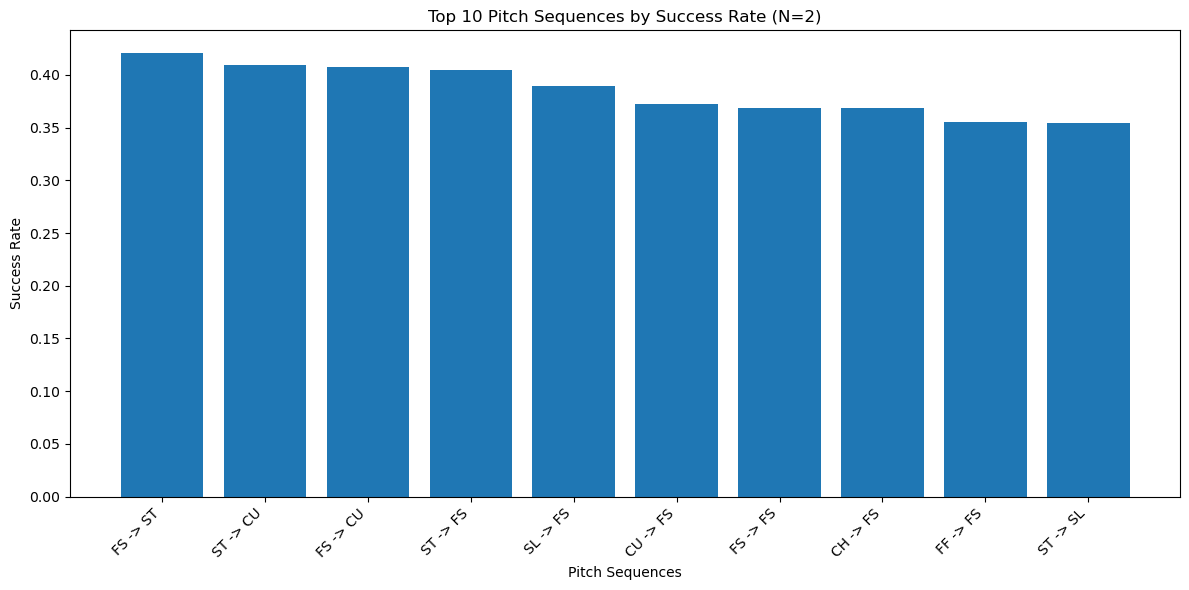

In [49]:
import matplotlib.pyplot as plt

# Select top N sequences
N = 10
top_N_ngrams = top_ngrams.head(N)

# Prepare labels for plotting
ngram_labels = [' -> '.join(ngram) for ngram in top_N_ngrams['ngram']]

# Plot
plt.figure(figsize=(12,6))
plt.bar(range(N), top_N_ngrams['success_rate'], tick_label=ngram_labels)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Pitch Sequences')
plt.ylabel('Success Rate')
plt.title(f'Top {N} Pitch Sequences by Success Rate (N={n})')
plt.tight_layout()
plt.show()


Top Pitch Sequences (N-grams) by Success Rate (N=3):
            ngram  total_occurrences  success_rate
433  (ST, FC, FS)                 11      0.636364
257  (ST, FS, ST)                 46      0.565217
439  (ST, SL, CH)                 18      0.555556
438  (SI, ST, FS)                 19      0.526316
405  (FC, ST, CU)                 65      0.523077
290  (CH, FC, ST)                 60      0.516667
366  (CU, FS, CU)                 78      0.512821
364  (FS, CU, CU)                 45      0.511111
385  (FS, ST, SI)                 12      0.500000
427  (FS, FC, ST)                 10      0.500000
476  (SL, FS, ST)                 16      0.500000
471  (CU, SL, FS)                 12      0.500000
255  (ST, ST, FS)                 75      0.480000
430  (CH, ST, CU)                 25      0.480000
260  (FS, ST, FS)                 44      0.477273
449  (CU, SL, ST)                 21      0.476190
391  (FC, ST, SL)                 19      0.473684
386  (ST, CU, FC)            

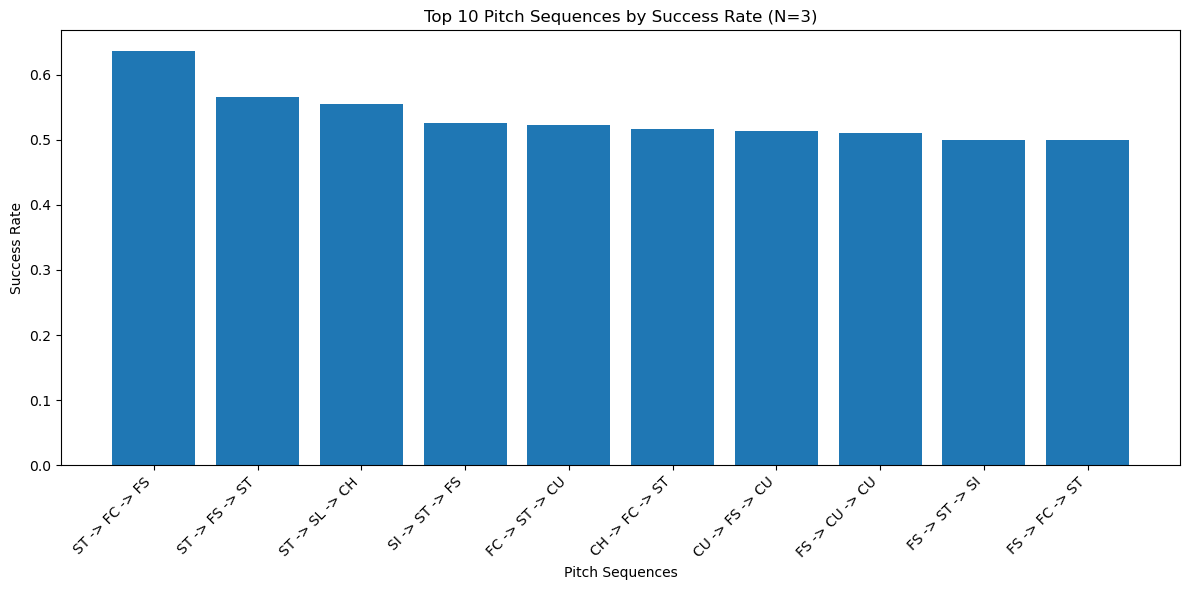

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt

def generate_ngrams(pitch_sequence, n):
    ngrams = []
    seq_length = len(pitch_sequence)
    for i in range(seq_length - n + 1):
        ngram = tuple(pitch_sequence[i:i+n])
        ngrams.append(ngram)
    return ngrams

# Set n for n-grams
n = 3  # Change to 2 for bigrams, 4 for quadgrams, etc.

# Dictionary to store outcomes for each n-gram
ngram_outcomes = defaultdict(list)

# Loop over sequences_df to extract n-grams and outcomes
for index, row in sequences_df.iterrows():
    pitch_sequence = row['pitch_sequence']
    outcome = row['label']  # 1 for success, 0 for failure
    ngrams = generate_ngrams(pitch_sequence, n)
    for ngram in ngrams:
        ngram_outcomes[ngram].append(outcome)

# Calculate success rates
ngram_stats = []

for ngram, outcomes in ngram_outcomes.items():
    total = len(outcomes)
    successes = sum(outcomes)
    success_rate = successes / total
    ngram_stats.append({
        'ngram': ngram,
        'total_occurrences': total,
        'successes': successes,
        'success_rate': success_rate
    })

ngram_stats_df = pd.DataFrame(ngram_stats)

# Set minimum occurrences for statistical significance
min_occurrences = 10  # Adjust based on data size

filtered_ngrams = ngram_stats_df[ngram_stats_df['total_occurrences'] >= min_occurrences]

# Sort by success rate
top_ngrams = filtered_ngrams.sort_values(by='success_rate', ascending=False)

# Display top sequences
print(f"Top Pitch Sequences (N-grams) by Success Rate (N={n}):")
print(top_ngrams[['ngram', 'total_occurrences', 'success_rate']].head(20))


# Plot
N = 10
top_N_ngrams = top_ngrams.head(N)
ngram_labels = [' -> '.join(ngram) for ngram in top_N_ngrams['ngram']]

plt.figure(figsize=(12,6))
plt.bar(range(N), top_N_ngrams['success_rate'], tick_label=ngram_labels)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Pitch Sequences')
plt.ylabel('Success Rate')
plt.title(f'Top {N} Pitch Sequences by Success Rate (N={n})')
plt.tight_layout()
plt.show()


In [53]:
print(f"Worst Pitch Sequences (N-grams) by Success Rate (N={n}):")
print(top_ngrams[['ngram', 'total_occurrences', 'success_rate']].tail(20))


Worst Pitch Sequences (N-grams) by Success Rate (N=3):
            ngram  total_occurrences  success_rate
148  (CH, FC, SI)                302      0.225166
36   (CH, SI, FC)                250      0.220000
99   (SI, CH, SI)               2005      0.214464
134  (SL, CH, SI)                471      0.212314
97   (CH, SI, SI)               1437      0.209464
407  (FC, FS, SI)                 53      0.207547
384  (ST, SI, FS)                 29      0.206897
271  (CU, CH, SI)                375      0.202667
334  (ST, SI, SL)                 36      0.194444
459  (CH, CU, ST)                 26      0.192308
383  (FS, SI, FF)                 64      0.187500
176  (FS, SI, SI)                230      0.186957
420  (SI, FS, CU)                 18      0.166667
412  (SL, CU, ST)                 12      0.166667
394  (ST, FS, SI)                 19      0.157895
408  (FS, SI, FC)                 32      0.156250
347  (ST, CH, CU)                 20      0.150000
419  (CU, FC, FS)          

In [57]:
fastballs = ['FF', 'SI']  # Four-Seam Fastball, Sinker
offspeed = ['FS', 'CH', 'FO']  # Splitter, Changeup, Forkball
breaking = ['CU', 'SL', 'FC', 'KC', 'ST', 'SC', 'EP']  # Curveball, Slider, Cutter, Knuckle Curve, Sweeper, Screwball, Eephus


In [58]:
# Function to map pitch types to categories
def map_pitch_to_category(pitch):
    if pitch in fastballs:
        return 'Fastball'
    elif pitch in offspeed:
        return 'Offspeed'
    elif pitch in breaking:
        return 'Breaking'
    else:
        return 'Other'
# Apply the mapping to create category sequences
sequences_df['category_sequence'] = sequences_df['pitch_sequence'].apply(
    lambda seq: [map_pitch_to_category(pitch) for pitch in seq]
)

In [59]:
# Check the new column
print(sequences_df[['pitch_sequence', 'category_sequence']].head())

         pitch_sequence                                  category_sequence
0  [CU, FC, SL, CU, CH]  [Breaking, Breaking, Breaking, Breaking, Offsp...
1                  [FC]                                         [Breaking]
2      [SI, FF, FC, SL]           [Fastball, Fastball, Breaking, Breaking]
3              [FC, CU]                               [Breaking, Breaking]
4                  [SL]                                         [Breaking]


In [60]:
from collections import defaultdict

def generate_ngrams(sequence, n):
    ngrams = []
    seq_length = len(sequence)
    for i in range(seq_length - n + 1):
        ngram = tuple(sequence[i:i+n])
        ngrams.append(ngram)
    return ngrams


In [ ]:
n = 2

# Dictionary to store outcomes for each bigram
ngram_outcomes_bigrams = defaultdict(list)

# Loop over sequences_df to extract bigrams and outcomes
for index, row in sequences_df.iterrows():
    category_sequence = row['category_sequence']
    outcome = row['label']  # 1 for success, 0 for failure
    ngrams = generate_ngrams(category_sequence, n)
    for ngram in ngrams:
        ngram_outcomes_bigrams[ngram].append(outcome)

ngram_stats_bigrams = []
for ngram, outcomes in ngram_outcomes_bigrams.items():
    total = len(outcomes)
    successes = sum(outcomes)
    success_rate = successes / total
    ngram_stats_bigrams.append({
        'ngram': ngram,
        'total_occurrences': total,
        'successes': successes,
        'success_rate': success_rate
    })

ngram_stats_bigrams_df = pd.DataFrame(ngram_stats_bigrams)
min_occurrences = 10  
filtered_bigrams = ngram_stats_bigrams_df[ngram_stats_bigrams_df['total_occurrences'] >= min_occurrences]
top_bigrams = filtered_bigrams.sort_values(by='success_rate', ascending=False)

# Display top bigrams, only 2^3 (8) options
print("Bigrams by Success Rate:")
print(top_bigrams[['ngram', 'total_occurrences', 'success_rate']].head(10))


Bigrams by Success Rate:
                  ngram  total_occurrences  success_rate
0  (Breaking, Breaking)              91007      0.326151
6  (Offspeed, Breaking)              15311      0.310757
3  (Fastball, Breaking)              87712      0.308897
8  (Offspeed, Offspeed)              21965      0.307808
1  (Breaking, Offspeed)              20743      0.292291
4  (Breaking, Fastball)              85165      0.285552
5  (Fastball, Offspeed)              35494      0.285175
2  (Fastball, Fastball)             129965      0.275767
7  (Offspeed, Fastball)              30935      0.274640


In [ ]:
n = 3

ngram_outcomes_trigrams = defaultdict(list)

for index, row in sequences_df.iterrows():
    category_sequence = row['category_sequence']
    outcome = row['label']
    ngrams = generate_ngrams(category_sequence, n)
    for ngram in ngrams:
        ngram_outcomes_trigrams[ngram].append(outcome)

ngram_stats_trigrams = []
for ngram, outcomes in ngram_outcomes_trigrams.items():
    total = len(outcomes)
    successes = sum(outcomes)
    success_rate = successes / total
    ngram_stats_trigrams.append({
        'ngram': ngram,
        'total_occurrences': total,
        'successes': successes,
        'success_rate': success_rate
    })

ngram_stats_trigrams_df = pd.DataFrame(ngram_stats_trigrams)

min_occurrences = 10

filtered_trigrams = ngram_stats_trigrams_df[ngram_stats_trigrams_df['total_occurrences'] >= min_occurrences]

top_trigrams = filtered_trigrams.sort_values(by='success_rate', ascending=False)

print("Top Trigrams by Success Rate:")
print(top_trigrams[['ngram', 'total_occurrences', 'success_rate']].head(20))


Top Trigrams by Success Rate:
                             ngram  total_occurrences  success_rate
0   (Breaking, Breaking, Breaking)              30538      0.358668
3   (Fastball, Breaking, Breaking)              27000      0.356259
24  (Offspeed, Offspeed, Offspeed)               4205      0.355054
11  (Offspeed, Breaking, Breaking)               3245      0.346687
2   (Fastball, Fastball, Breaking)              30082      0.337544
5   (Fastball, Offspeed, Breaking)               5111      0.336138
1   (Breaking, Breaking, Offspeed)               4596      0.333551
17  (Breaking, Fastball, Breaking)              24436      0.331969
16  (Offspeed, Offspeed, Breaking)               2855      0.330648
20  (Fastball, Offspeed, Offspeed)               8378      0.324063
18  (Fastball, Breaking, Offspeed)               5641      0.323524
15  (Breaking, Offspeed, Offspeed)               4100      0.322195
14  (Breaking, Offspeed, Breaking)               4464      0.322133
10  (Offspeed, Fas